# Physical Beamformer testing

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from scipy.signal import resample
from playsound import playsound

### Build Anechoic Simulation Room

In [8]:
fs = 48000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # stage width
room_y = 10 # room length
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
v_sound = 343.0 # speed of sound in air

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption

room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)

### Place mics

In [9]:
# design parameters of array
array_loc = [5, 0.1] # x/y location of array center
n_mics = 8 # number of microphones
sep = 0.3 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, room.fs, N) # uses omnidirectional mics by default
room.add_microphone_array(mic_array)

### Load Recorded Signals

Stores them in microphone objects

In [10]:
mic_signals_filepath = '../array_samples/two_source_sinusoid_30cm/0'
signals_suffix = '-240917_0923.wav'

for i in range(n_mics):
    file_str = mic_signals_filepath + str(i+1) + signals_suffix
    f_sample, audio = wavfile.read(file_str)

    if i == 0:
        mic_signals = np.zeros((n_mics, len(audio)))

    mic_signals[n_mics-1-i, :] = audio

room.mic_array.signals = mic_signals

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_36104/1427140451.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  f_sample, audio = wavfile.read(file_str)


### Isolate sources with beamforming

In [14]:
# add guessed locations of sources to room
n_source = 2
doa_azimuths = np.array([55.86206897, 93.10344828])*np.pi/180.0 # from DOA

# add guessed locations of sources to room
guess_dist = 5 # guessed distance away from array - choose far distance for precise beam
guess_source_locs = np.empty((2, n_source))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
out_filepath = '../output_samples/physical_tests'

for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])
    print(source.images)

    mic_array.rake_delay_and_sum_weights(
        source=source,
        interferer=interf,
        R_n=sigma2_n * np.eye(mic_array.M) # estimated noise covariance matrix
    )
    mic_array.filters_from_weights() # process with time domain filters for now, can also use FD directly

    # compute SIR, averaged across all frequency bands
    SIR_sum = 0
    for f in mic_array.frequencies:
        current_SIR = mic_array.snr(source, interf, f, dB=True)
        if math.isnan(current_SIR) == False:
            SIR_sum += current_SIR
            print(f'frequency band: {f:.2f}, SINR: {current_SIR:.2f}')
    SIR_avg = SIR_sum / len(mic_array.frequencies)
    print(f'average SINR: {SIR_avg:.2f}')

    # save processed sound as output
    output = mic_array.process()
    out_norm = pra.normalize(output)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '.wav', fs, out_norm)

[[7.80593533]
 [4.23844499]]
frequency band: 0.00, SINR: 0.13
frequency band: 46.88, SINR: 0.69
frequency band: 93.75, SINR: 2.48
frequency band: 140.62, SINR: 5.90
frequency band: 187.50, SINR: 12.37
frequency band: 234.38, SINR: 44.08
frequency band: 281.25, SINR: 16.07
frequency band: 328.12, SINR: 12.89
frequency band: 375.00, SINR: 13.70
frequency band: 421.88, SINR: 18.27
frequency band: 468.75, SINR: 38.63
frequency band: 515.62, SINR: 21.14
frequency band: 562.50, SINR: 16.88
frequency band: 609.38, SINR: 16.91
frequency band: 656.25, SINR: 20.69
frequency band: 703.12, SINR: 36.39
frequency band: 750.00, SINR: 23.67
frequency band: 796.88, SINR: 18.72
frequency band: 843.75, SINR: 18.23
frequency band: 890.62, SINR: 21.43
frequency band: 937.50, SINR: 33.75
frequency band: 984.38, SINR: 24.58
frequency band: 1031.25, SINR: 19.11
frequency band: 1078.12, SINR: 18.19
frequency band: 1125.00, SINR: 20.81
frequency band: 1171.88, SINR: 30.00
frequency band: 1218.75, SINR: 23.72
fr

### Evaluate performance

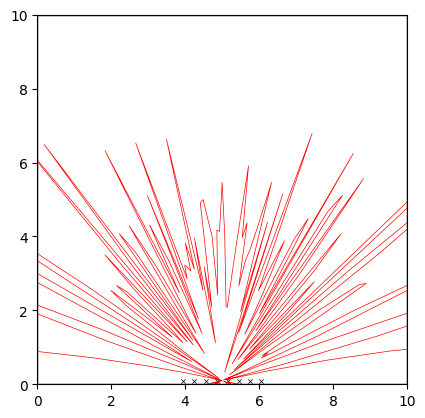

In [17]:
# plot peam pattern
fig, ax = room.plot(freq=[5000], img_order=0)